# Transformer-based Text Classfication

This notebook shows hot to make use of pre-trained Transformer models for building various types of text classifiers, some of which are multi-lingual. In particular, the notebook demonstrates the training of BERT-based text classifiers for:
- categorising news group messages
- detecting sentiment in Twitter messages
- determining if a sentence paraphrases another.

The notebook makes use of:
- Transformer models from HuggingFace for training: https://github.com/huggingface/transformers
- Lime for explanations: https://lime-ml.readthedocs.io/en/latest/index.html

Much of the notebook is based on:
- this Google Colab notebook: https://colab.research.google.com/drive/1YxcceZxsNlvK35pRURgbwvkgejXwFxUt
- this notebook: https://github.com/amaiya/ktrain/blob/master/examples/text/MRPC-BERT.ipynb


## Prepare environment

**NOTE**: To run this notebook, you will **need a GPU** (Graphics Processing Unit) card
- the notebook has been tested on Google Colab and you are advised to run it there
- to use a GPU, you need to click on "Runtime" above, then "Change runtime type" and for "Hardware accelerator" choose the "GPU" option

Now we should install and import all the dependencies, colab comes with all the libraries already pre-installed in the runtime, but datasets:

In [1]:
#!pip3 install torch
#!pip3 install -q transformers datasets
#!pip3 install --upgrade scikit-learn==1.0.2
#!pip3 install matplotlib
#!pip3 install accelerate -U

In [106]:
!pip install -q datasets

You may need to restart the environment after installing the dependancies at this point

In [3]:
import torch
import numpy as np

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

Now let's check if our runtime is using a GPU

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


`'cuda'`(Compute Unified Device Architecture) is an API developed by NVIDIA that allows software to utilize GPUs for general-purpose computing. So if torch is detecting a cuda device, it means it is detecting a GPU!

## Classification on the 20 Newsgroups dataset

In the first example  

Training on all of the documents in the dataset will take too long (a few hours), so we'll use just 4 today.
- If you want to try on the full dataset, just remove the 'categories' attribute from the commands below.
- Be warned though, that training time will be MUCH longer if you include all of the data, so first try subset of the categories.

In [7]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'alt.atheism']
train = fetch_20newsgroups(subset='train', shuffle=True, categories=categories)
test = fetch_20newsgroups(subset='test', shuffle=True, categories=categories)

Print out some basic information about the dataset:

In [8]:
print('# train instances: ', len(train.data))
print('# test instances:  ', len(test.data))
print('classes: ', train.target_names)

# train instances:  2255
# test instances:   1501
classes:  ['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med']


Let's compute the occurrences of the classes

In [9]:
from collections import Counter

counts = Counter(train.target)
counts

Counter({np.int64(3): 594,
         np.int64(2): 597,
         np.int64(1): 584,
         np.int64(0): 480})

A class count shows that there is a relatively even distribution of messages across the categories:

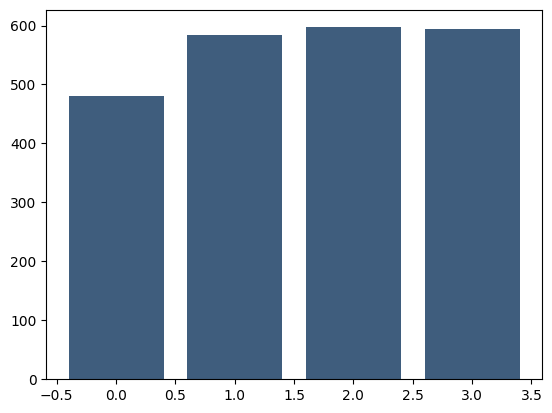

In [10]:
import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values(), color="#3F5D7D", width=0.8);

### Model training and evaluation

#### Creating a model and preprocessing data

For the moment we will use the standard pretrained Multilingual BERT model. Note that this **model is big**!
- it contains 110 million parameters
- it represents words (subword tokens to be precise) with embeddings of size 768 <-- compare this with the 50 dimensions we used with GloVe
- it contains 12 self-attention layers (each with 12 heads) stacked on top each other

In [11]:
model_name = 'bert-base-multilingual-uncased'

There are many other pretrained models availalable here: https://huggingface.co/transformers/pretrained_models.html
- Give them a try and see which ones are faster and/or more stable to train!

Load the transformer setting the maximum text length to 500 and the classes to be the four newsgroup categories mentioned above.

In [12]:
bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Move model to GPU

In [13]:
bert = bert.to(device)

Now that we've downloaeded the base Multiligual BERT model, let's have a look at the architecture.

In [14]:
print(bert)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

Check which of the parameters are trainable:

In [15]:
for param in bert.parameters():
    print(param.size(), param.requires_grad)

torch.Size([105879, 768]) True
torch.Size([512, 768]) True
torch.Size([2, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([3072, 768]) True
torch.Size([3072]) True
torch.Size([768, 3072]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([3072, 768]) True
torch.Size([3072]) True
torch.Size([768, 3072]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768,

Load the tokenizer

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Now we can preprocess the training (and test) data using the transformer's data set API

First create a list of dictionaries with all the samples in the train and test data sets

In [17]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(train.data, train.target)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test.data, test.target)]

Convert the data sets into the Huggingface data set API format

In [18]:
train_data = Dataset.from_list(train_data)
test_data = Dataset.from_list(test_data)

Create a container with all the splits of the data set

**Note**: We are using the same data for validation and testing, this is not a good practice, it's just for the tutorial, in general you should have separate data for validation and test.

In [19]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = test_data
data['test'] = test_data

Finally use the tokenizer to convert the input strings into sequences of tokens (more on this later)

In [20]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/2255 [00:00<?, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

Let's have a quick look at what the tokenised data looks like:
- First print out the text of the first document:

In [21]:
print(train.data[0])

From: cab@col.hp.com (Chris Best)
Subject: Re: Is MSG sensitivity superstition?
Organization: your service
Lines: 20
NNTP-Posting-Host: hpctdkz.col.hp.com


Jason Chen writes:
> Now here is a new one: vomiting. My guess is that MSG becomes the number one
> suspect of any problem. In this case. it might be just food poisoning. But
> if you heard things about MSG, you may think it must be it.

----------

Yeah, it might, if you only read the part you quoted.  You somehow left 
out the part about "we all ate the same thing."  Changes things a bit, eh?

You complain that people blame MSG automatically, since it's an unknown and
therefore must be the cause.  It is equally (if not more) unreasonable to
defend it, automatically assuming that it CAN'T be the culprit.

Pepper makes me sneeze.  If it doesn't affect you the same way, fine.
Just don't tell me I'm wrong for saying so.

These people aren't condemning Chinese food, Mr. Chen - just one of its 
(optional) ingredients.  Try not to take 

Now print out the result of preprocessing the first document:

Each sample in tokenized_data is a dictionary with these keys

In [22]:
tokenized_data['train'][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

Let's inspect the input_ids and labels

In [23]:
print(tokenized_data['train'][0]['input_ids'])

[101, 10195, 131, 70438, 137, 12308, 119, 20931, 119, 10241, 113, 13446, 11146, 114, 19513, 131, 11449, 131, 10127, 16777, 10251, 20242, 14119, 52902, 12278, 12054, 11101, 136, 14935, 131, 12787, 11416, 17294, 131, 10200, 37580, 84723, 118, 42191, 10422, 118, 17624, 131, 20931, 15106, 10163, 10167, 10311, 119, 12308, 119, 20931, 119, 10241, 17110, 20728, 47332, 131, 135, 11628, 14048, 10127, 143, 10246, 10399, 131, 11106, 69431, 119, 11153, 41567, 22523, 10127, 10203, 16777, 10251, 23259, 10103, 11395, 10399, 135, 75695, 10108, 11318, 15640, 119, 10104, 10372, 12700, 119, 10197, 20025, 10346, 12125, 15225, 55340, 10285, 119, 10502, 135, 11526, 10855, 27134, 17994, 10935, 16777, 10251, 117, 10855, 10431, 21506, 10197, 14650, 10346, 10197, 119, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 82600, 117, 10197, 20025, 117, 11526, 10855, 10902, 18593, 10103, 10649, 10855, 62259, 119, 10855, 10970, 38644, 12174, 10871, 10103, 10649, 10935, 107, 11312, 10367, 12811, 10103, 11714, 21973, 11

In [24]:
print(tokenized_data['train'][0]['label'])

3


Each integer above is the index of a token from the vocabulary of the BERT model.
- How big is the vocabulary?

In [25]:
print("vocabulary size: ", len(tokenizer.vocab))

vocabulary size:  105879


This vocabulary is relatively small compared to many word embeddings discussed in the lecture, which often reach over 1 million distinct words.
- The vocab size is kept relatively small through the use of sub-word tokens that are found using a byte-pair encoding scheme.
- We can take a single string and run it through the tokenizer to see the tokens produced as follows:

In [26]:
example_text = "I always wondered what those Transformer models were doing to my text. Here is a OutOfVocabWord."
encoded_text = tokenizer(example_text).input_ids
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("input text: "+example_text)
print("tokenized:  ", [vocab_terms[vocab_index.index(i)] for i in encoded_text])

input text: I always wondered what those Transformer models were doing to my text. Here is a OutOfVocabWord.
tokenized:   ['[CLS]', 'i', 'always', 'wonder', '##ed', 'what', 'those', 'transforme', '##r', 'models', 'were', 'doing', 'to', 'my', 'text', '.', 'here', 'is', 'a', 'out', '##of', '##vo', '##ca', '##b', '##word', '.', '[SEP]']


Note that:
- a '[CLS]' token has been added to the start of the tokenized text and a '[SEP]' token to the end.
- BERT works as a masked autoencoder, meaning that it is trained to produce the same terms as output that are presented in input, including those that were masked out.
- the '[CLS]' token is simply a special mask for the unknown class label that needs to be produced at the output.
- the Byte-Pair Encoding has removed the suffixes from certain words (e.g. 'wondered' lost the 'ed'), but not all of them ('models' kept the 's').

#### Training the model

Now we're ready to start training the model.

Prepare training arguments (including a name for the trainer)

In [27]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [28]:
training_args = TrainingArguments(
    "cool_trainer_name",
    per_device_train_batch_size=16,
    report_to=None,  # Disabling wandb callbacks
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Disable weights in model encoder

In [29]:
for param in bert.bert.parameters():
    param.requires_grad = True

Build the traininer using the Huggingface trainer API

In [30]:
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation']
)

Finally, run the training process (we train for three epochs)



In [31]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=423, training_loss=0.1270557340437075, metrics={'train_runtime': 686.021, 'train_samples_per_second': 9.861, 'train_steps_per_second': 0.617, 'total_flos': 1779978252349440.0, 'train_loss': 0.1270557340437075, 'epoch': 3.0})

#### Evaluating the model

Now that the model has finished training, let's evaluate in on the test data.

First we can run the evaluation process included with the trainer

In [32]:
trainer.evaluate()

{'eval_loss': 0.14979565143585205,
 'eval_runtime': 46.2792,
 'eval_samples_per_second': 32.434,
 'eval_steps_per_second': 4.062,
 'epoch': 3.0}

Then we can get the predictions on the test set...

In [33]:
preds = trainer.predict(tokenized_data['test'])
preds

PredictionOutput(predictions=array([[ 6.0067897, -1.6743139, -1.8772786, -1.9553874],
       [-1.671964 ,  5.657428 , -2.440147 , -1.3884177],
       [-1.7995558,  5.769787 , -2.142156 , -1.8255823],
       ...,
       [-1.3436375, -1.4887947, -1.8155373,  5.2356   ],
       [-2.1362324,  5.802923 , -2.0344894, -1.6750643],
       [-1.1985577, -1.8716185, -1.9975036,  5.8220367]], dtype=float32), label_ids=array([0, 1, 1, ..., 3, 1, 3]), metrics={'test_loss': 0.14979565143585205, 'test_runtime': 45.6469, 'test_samples_per_second': 32.883, 'test_steps_per_second': 4.119})

Convert predicted logits to classes using the $\mathrm{argmax}$ operator

In [34]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred

array([0, 1, 1, ..., 3, 1, 3])

Get target label names

In [35]:
label_names = test.target_names

... and use them to preprare a classification report using Scikit-Learn API

In [36]:
print(classification_report(test.target, y_pred, target_names=label_names))

                    precision    recall  f1-score   support

       alt.atheism       0.97      0.95      0.96       319
     comp.graphics       0.96      0.98      0.97       389
rec.sport.baseball       0.98      0.98      0.98       397
           sci.med       0.98      0.96      0.97       396

          accuracy                           0.97      1501
         macro avg       0.97      0.97      0.97      1501
      weighted avg       0.97      0.97      0.97      1501



... or compute a confusion matrix using the Scikit-Learn API

In [37]:
print(confusion_matrix(test.target, y_pred))

[[304   3   4   8]
 [  3 383   3   0]
 [  1   4 391   1]
 [  7   7   2 380]]


We can have a look at the test examples on which the model made the worst predictions:

Compute loss

In [38]:
loss = torch.nn.functional.cross_entropy(torch.tensor(preds.predictions), torch.tensor(preds.label_ids), reduction='none')
loss

tensor([0.0012, 0.0018, 0.0014,  ..., 0.0035, 0.0013, 0.0017])

Identify the index of the element with the highest loss

In [39]:
index_of_instance = torch.argmax(loss).item()
index_of_instance

1196

Loss of the corresponding sample

In [40]:
loss[index_of_instance].item()

7.921477317810059

Predicted class and target class

In [41]:
print(f'Target class:    {label_names[test.target[index_of_instance]]}')
print(f'Predicted class: {label_names[y_pred[index_of_instance]]}')

Target class:    sci.med
Predicted class: alt.atheism


Print out the post with the top loss (by changing INDEX_OF_INSTANCE below) to try to find out why it is confusing the classfier.

In [42]:
print(test.data[index_of_instance])

From: turpin@cs.utexas.edu (Russell Turpin)
Subject: Meaning of atheism, agnosticism  (was: Krillean Photography)
Organization: CS Dept, University of Texas at Austin
Lines: 23
NNTP-Posting-Host: saltillo.cs.utexas.edu

-*----
Sci.med removed from followups.  (And I do not read any of the
other newsgroups.)

-*----
In article <1993Apr30.170233.12510@rosevax.rosemount.com> grante@aquarius.rosemount.com (Grant Edwards) writes:
> As a self-proclaimed atheist my position is that I _believe_ that 
> there is no god.  I don't claim to have any proof.  I interpret
> the agnostic position as having no beliefs about god's existence.

That's fine.  These words have multiple meanings.

As a self-proclaimed atheist, I believe that *some* conceptions
of god are inconsistent or in conflict with fact, and I lack
belief in other conceptions of god merely because there is no
reason for me to believe in these.  I usually use the word
agnostic to mean someone who believes that the existence of
a god is u

### Making predictions on new data

We can run the trained classification model on new examples.

#### Utility functions

Define a simple function to make a prediction

In [43]:
@torch.no_grad()
def predict(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    lbl = label_names[torch.argmax(outputs.logits).item()]

    return lbl

Define  simple function to predict the classes probabilities

In [44]:
@torch.no_grad()
def predict_proba(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    proba = torch.softmax(outputs.logits, dim=1).cpu().squeeze().numpy()


    return dict(zip(label_names, proba))

We can now try the trained model on new samples

In [45]:
sample_text = 'Both of the home runs hit by Fernando Tatís in the third inning for the St. Louis Cardinals on April 23, 1999, were grand slams.'
predict(sample_text)

'rec.sport.baseball'

We can see the probabilities assigned by the model to each of the classes as follows:

In [46]:
predict_proba(sample_text).values()

dict_values([np.float32(0.00034700456), np.float32(0.0004626584), np.float32(0.9986625), np.float32(0.00052784063)])

Where the classes are:

In [47]:
predict_proba(sample_text).keys()

dict_keys(['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med'])

OK, so the model appears to work well on English text.

#### Multi-lingual examples

Let's try on a phrase in another language (Italian).
- Note that the news group data we used to train the model is in English only, so the model has never seen any examples of news group messages in Italian.

In [48]:
italian_text = 'I tasti su e giù sul mio portatile non funzionano più, quindi non posso più usarlo per giocare ;-('
predict(italian_text)

'comp.graphics'

In [49]:
predict_proba(italian_text)

{'alt.atheism': np.float32(0.00052412815),
 'comp.graphics': np.float32(0.99800926),
 'rec.sport.baseball': np.float32(0.00053345837),
 'sci.med': np.float32(0.0009332685)}

Did it get the prediction right?
- Note that while the characer set for Italian and English is almost the same, there weren't any words (except perhaps for "non") in the above message that would have occurred in the training data.

Let's try a message in a different character set:
- Translate the text into Chinese using Google Translate: https://translate.google.com/
- Then copy the text below and rerun the prediction.
- Does it still work?



In [50]:
chinese_text = '笔记本电脑上的向上和向下键不再起作用，因此我无法再使用它来播放;-(' #'INSERT CHINESE TEXT HERE'
predict(chinese_text)

'comp.graphics'

In [51]:
russian_text = "Клавиши «вверх» и «вниз» на моем ноутбуке больше не работают, поэтому я больше не могу использовать их для игры ;-("
predict(russian_text)

'comp.graphics'

### Explaining the predictions

Let's try another piece of text, this time in English, but talking about a politician who wasn't a politician (but rather a celebrity) at the time in which the 20 News Groups dataset was created:

In [52]:
sample_text = 'Donald Trump is the greatest living ex-president in the history of living ex-presidents. He\'s also a bad golfer.'
predict(sample_text)

'rec.sport.baseball'

Let's invoke the `explain` method to see which words contribute most to the classification.

We will need to install the **eli5** library.

In [108]:
!pip uninstall -yq flask
!pip install eli5

We need an additional apssage to make ELI5 work in this environment

In [54]:
import scipy
import numpy as np
def monkeypath_itemfreq(sampler_indices):
   return zip(*np.unique(sampler_indices, return_counts=True))

scipy.stats.itemfreq=monkeypath_itemfreq

In [55]:
import eli5
from eli5.lime import TextExplainer

Define function to output the probability distribution as a matrix `(n_samples, n_classes)`

In [56]:
@torch.no_grad()
def predict_proba_values(text):
    input_encodings = tokenizer(text, return_tensors='pt', padding=True).to(device)
    outputs = bert(**input_encodings)

    proba = torch.softmax(outputs.logits, dim=1).cpu().squeeze().numpy()

    return proba

Run the explainer (based on LIME) to see which words in the sentence are most important for the prediction:

In [57]:
# See https://amaiya.github.io/ktrain/text/predictor.html
# See https://eli5.readthedocs.io/en/latest/autodocs/lime.html
def explain(text, truncate_len=512, all_targets=False, n_samples=2500):
    prediction = [predict(text)] if not all_targets else None
    text = " ".join(text.split()[:truncate_len])
    te = TextExplainer(random_state=42, n_samples=n_samples)
    _ = te.fit(text, predict_proba_values)
    return te.show_prediction(
        target_names=label_names, targets=prediction
    )

In [58]:
explain(sample_text)

The words in the darkest shade of green contribute most to the classification.
- Do they agree with what you would have expected for this example?

### Inspecting the Model

Let's have a look at the architecture of the model that we have used:

In [59]:
print(bert)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

Compute the total number of parameters

In [60]:
n_params = sum(param.numel() for param in bert.parameters())
n_params

167359492

The model contains over 100 million parameters consists of:
- BERT (which contains alost all the parameters),
- a drop-out layer (that is inserted to prevent overfitting), and
- a dense (feedforward) layer to map the BERT embedding of size 768 to the 2 output neurons (representing the positive and negative classes).

Let's print out information on the configuration of BERT.

In [61]:
bert.bert.config

BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.50.0",
  "type_vocab_size": 2,

### Saving and loading a fine-tuned model

We can save predictor for later use

In [62]:
bert.save_pretrained('/tmp/my_predictor')

Reload the predictor and use it to predict the class of a new piece of text:

In [63]:
bert = AutoModelForSequenceClassification.from_pretrained('/tmp/my_predictor').to(device)
predict('My computer monitor is really blurry.')

'comp.graphics'

## Classifying the sentiment of Twitter messages

We'll now train a different model to detect sentiment on Twitter data as we did for the previous tutorials:

In [64]:
!pip3 install nltk

In [65]:
import nltk
nltk.download('twitter_samples')

from nltk.corpus import twitter_samples
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

import re
emoticon_regex = '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)'
positive_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in positive_tweets]
negative_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in negative_tweets]

tweets_x = positive_tweets_noemoticons + negative_tweets_noemoticons
tweets_y = ['positive']*len(positive_tweets) + ['negative']*len(negative_tweets)

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


Use scikit-learn to split the data into training, validation and test sets:


In [66]:
from sklearn.model_selection import train_test_split
temp_x, test_x, temp_y, test_y = train_test_split(tweets_x, tweets_y, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

Now **repeat** all the steps from before for the twitter data:

1.   Load the model (this time we'll try DistilBERT, which is a smaller transformer model)

In [67]:
model_name = 'distilbert-base-uncased'
bert = bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
bert = bert.to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2. Process the training/test data

In [68]:
train_data = [{'text': txt, 'label': 0 if lbl == 'negative' else 1} for txt, lbl in zip(train_x, train_y)]
validation_data = [{'text': txt, 'label': 0 if lbl == 'negative' else 1} for txt, lbl in zip(valid_x, valid_y)]
test_data = [{'text': txt, 'label': 0 if lbl == 'negative' else 1} for txt, lbl in zip(test_x, test_y)]

In [69]:
train_data = Dataset.from_list(train_data)
validation_data = Dataset.from_list(validation_data)
test_data = Dataset.from_list(test_data)

3. Create a data loaders

In [70]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = validation_data
data['test'] = test_data

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True, batch_size=6400)

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

4.   Train the model (We'll run for one epoch to make it faster, but it would be better to run for 4 or more)

In [71]:
training_args = TrainingArguments(
    "cool_trainer_name_1",
    per_device_train_batch_size=16,
    report_to=None,  # Disabling wandb callbacks

)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Possibly disable wights

In [72]:
 #for param in bert.base_model.parameters():
 #    param.requires_grad = False

In [73]:
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation']
)

In [74]:
trainer.train()

Step,Training Loss
500,0.417900
1000,0.181600


TrainOutput(global_step=1200, training_loss=0.270679604212443, metrics={'train_runtime': 213.6684, 'train_samples_per_second': 89.859, 'train_steps_per_second': 5.616, 'total_flos': 586168239052800.0, 'train_loss': 0.270679604212443, 'epoch': 3.0})

5.   Evaluate the model

In [75]:
trainer.evaluate()

{'eval_loss': 0.6484460234642029,
 'eval_runtime': 3.7696,
 'eval_samples_per_second': 424.447,
 'eval_steps_per_second': 53.056,
 'epoch': 3.0}

In [76]:
preds = trainer.predict(tokenized_data['test'])
preds

PredictionOutput(predictions=array([[ 1.6933244 , -1.5906924 ],
       [-2.983489  ,  3.6800168 ],
       [-2.099105  ,  2.4160726 ],
       ...,
       [ 2.3235343 , -2.190914  ],
       [-0.48897102,  0.7566009 ],
       [ 0.321245  , -0.1095224 ]], dtype=float32), label_ids=array([0, 1, 1, ..., 0, 1, 0]), metrics={'test_loss': 0.6251190304756165, 'test_runtime': 4.0467, 'test_samples_per_second': 494.226, 'test_steps_per_second': 61.778})

Convert predicted logits to classes using the $\mathrm{argmax}$ operator

In [77]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred

array([0, 1, 1, ..., 0, 1, 0])

Get target label names

In [78]:
label_names = ['negative', 'positive']

... and use them to preprare a classification report using Scikit-Learn API

In [79]:
print(classification_report([0 if lbl == 'negative' else 1 for lbl in test_y], y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.81      0.86      0.83       988
    positive       0.85      0.80      0.83      1012

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



6.   Make some predictions with it

In [80]:
@torch.no_grad()
def predict(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    lbl = label_names[torch.argmax(outputs.logits).item()]

    return lbl

In [81]:
# predict('Had a lot of fun today!')
predict('Today was really hard to give the lecture with the broken code')

'negative'

Did it work?

Let's print out some information about the architecture of this model:

In [82]:
print(bert)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


We see that the distilbert model has fewer parameters than the BERT model we used previously. It's interesting to see the pre-classifier layer in this model that maps the output embeddings from the transformer into a second embedding space (of the same size) that is then used as features for the final classification layer.


## Pairwise classification task

We now use the Microsoft Research Paraphrase Corpus (MRPC) to build a classifier for detecting paraphrased sentences.
- This is an example of a paired sentence classfication task, where the prediction model takes in a **pair of texts as input** and produces a **binary label as output**.

We'll first use pandas (Python's data analysis library) to download and parse the tab-separated data:

In [83]:
import pandas as pd
import csv
train_file = 'https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt'
test_file = 'https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt'
train_df = pd.read_csv(train_file, delimiter='\t', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(test_file, delimiter='\t', quoting=csv.QUOTE_NONE)

In [84]:
train_df

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...
...,...,...,...,...,...
4071,1,1620264,1620507,""" At this point , Mr. Brando announced : ' Som...","Brando said that "" somebody ought to put a bul..."
4072,0,1848001,1848224,"Martin , 58 , will be freed today after servin...",Martin served two thirds of a five-year senten...
4073,1,747160,747144,""" We have concluded that the outlook for price...","In a statement , the ECB said the outlook for ..."
4074,1,2539933,2539850,The notification was first reported Friday by ...,MSNBC.com first reported the CIA request on Fr...


We need to format the training data in the format needed for ktrain
- so select the two columns containing strings
- and get their values (as an 2d array)
- then convert the array to a list of tuples (str,str) as required by ktrain:

In [85]:
x_train = train_df[['#1 String', '#2 String']].values
x_train = list(map(tuple, x_train))

Repeat for the test data:

In [86]:
x_test = test_df[['#1 String', '#2 String']].values
x_test = list(map(tuple, x_test))

And of course, we need also the labels for the training / test examples:

In [87]:
y_train = train_df['Quality'].values
y_test = test_df['Quality'].values

Print out sizes of dataset:


In [88]:
print("# train instances: ",len(x_train))
print("# test instances:  ",len(x_train))

# train instances:  4076
# test instances:   4076


Have a look at a random sentence pair:

In [89]:
import random
i = random.randint(0,len(x_train)-1)
print("Index:      "+str(i))
print("Sentance 1: "+x_train[i][0])
print("Sentence 2: "+x_train[i][1])
print("Label:      "+str(y_train[i]))

Index:      2619
Sentance 1: On Monday , Christian Ganczarski was apprehended at the airport and was to appear before an anti-terrorism judge soon , the officials said .
Sentence 2: On Monday , Christian Ganczarski was apprehended at the airport and was to appear before an anti-terrorism judge in the coming days , the officials said on condition of anonymity .
Label:      1


1. Load model

In [90]:
model_name = 'distilbert-base-uncased'  # 'bert-large-uncased'
bert = bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
bert = bert.to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2. Prepare data

In [91]:
train_data = [{'sent1': txt[0], 'sent2': txt[1], 'label': lbl} for txt, lbl in zip(x_train, y_train)]
test_data = [{'sent1': txt[0], 'sent2': txt[1], 'label': lbl} for txt, lbl in zip(x_test, y_test)]

In [92]:
train_data = Dataset.from_list(train_data)
test_data = Dataset.from_list(test_data)

Here we need to change a bit the tokenisation step, because we need to tokenise the two sentences together separated byt the special '\[SEP\]' token

In [93]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = test_data
data['test'] = test_data

def tokenize_function(examples):
    return tokenizer(examples["sent1"], examples["sent2"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True, batch_size=4096)

Map:   0%|          | 0/4076 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

How do the samples look like?
Let's consider the sentence pair we extacted randomly before

In [94]:
sentence1 = tokenized_data['train'][i]["sent1"]
sentence1 = tokenized_data['train'][i]["sent2"]
encoded_text = tokenized_data['train'][i]["input_ids"]
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("Sentance 1: "+sentence1)
print("Sentence 2: "+sentence1)
print("tokenized:  ", [vocab_terms[vocab_index.index(i)] for i in encoded_text])

Sentance 1: On Monday , Christian Ganczarski was apprehended at the airport and was to appear before an anti-terrorism judge in the coming days , the officials said on condition of anonymity .
Sentence 2: On Monday , Christian Ganczarski was apprehended at the airport and was to appear before an anti-terrorism judge in the coming days , the officials said on condition of anonymity .
tokenized:   ['[CLS]', 'on', 'monday', ',', 'christian', 'gan', '##cz', '##ars', '##ki', 'was', 'app', '##re', '##hend', '##ed', 'at', 'the', 'airport', 'and', 'was', 'to', 'appear', 'before', 'an', 'anti', '-', 'terrorism', 'judge', 'soon', ',', 'the', 'officials', 'said', '.', '[SEP]', 'on', 'monday', ',', 'christian', 'gan', '##cz', '##ars', '##ki', 'was', 'app', '##re', '##hend', '##ed', 'at', 'the', 'airport', 'and', 'was', 'to', 'appear', 'before', 'an', 'anti', '-', 'terrorism', 'judge', 'in', 'the', 'coming', 'days', ',', 'the', 'officials', 'said', 'on', 'condition', 'of', 'an', '##ony', '##mity', 

2. Build and train a model:

In [95]:
training_args = TrainingArguments(
    "cool_trainer_name",
    per_device_train_batch_size=16,
    report_to=None,  # Disabling wandb callbacks
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Possibly disable wights

In [96]:
#for param in bert.base_model.parameters():
#    param.requires_grad = False

In [97]:
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation']
)

In [98]:
trainer.train()

Step,Training Loss
500,0.392600


TrainOutput(global_step=765, training_loss=0.3031355714486315, metrics={'train_runtime': 121.2963, 'train_samples_per_second': 100.811, 'train_steps_per_second': 6.307, 'total_flos': 325860486579792.0, 'train_loss': 0.3031355714486315, 'epoch': 3.0})

3. Evaluate model

In [99]:
trainer.evaluate()

{'eval_loss': 0.6390179991722107,
 'eval_runtime': 5.7451,
 'eval_samples_per_second': 300.256,
 'eval_steps_per_second': 37.597,
 'epoch': 3.0}

In [100]:
preds = trainer.predict(tokenized_data['test'])
preds

PredictionOutput(predictions=array([[-2.726364 ,  2.8330874],
       [ 0.4921037, -0.5208428],
       [-2.6954074,  2.771809 ],
       ...,
       [-2.0080771,  2.0954912],
       [-2.6790872,  2.7877517],
       [-2.7061663,  2.7669861]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 1, 1]), metrics={'test_loss': 0.6390179991722107, 'test_runtime': 5.7492, 'test_samples_per_second': 300.043, 'test_steps_per_second': 37.571})

Convert predicted logits to classes using the $\mathrm{argmax}$ operator

In [101]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred

array([1, 0, 1, ..., 1, 1, 1])

Get target label names

In [102]:
label_names = ['not-paraphrase', 'paraphrase']

... and use them to preprare a classification report using Scikit-Learn API

In [103]:
print(classification_report(y_test, y_pred, target_names=label_names))

                precision    recall  f1-score   support

not-paraphrase       0.79      0.70      0.74       578
    paraphrase       0.86      0.90      0.88      1147

      accuracy                           0.84      1725
     macro avg       0.82      0.80      0.81      1725
  weighted avg       0.83      0.84      0.83      1725



4. Test the model on a pair of sentences:

In [104]:
@torch.no_grad()
def predict(sent1, sent2):
    input_encodings = tokenizer(sent1, sent2, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    lbl = label_names[torch.argmax(outputs.logits).item()]

    return lbl

In [105]:
predict("I 'm eating pizza today", "She's eating pizza today")
#predict("I think I will eat some pizza today", "My flight was delayed")

'paraphrase'

Did it work?
- Try it out on some of your own sentences!